# ASTR 19 Final Project
<b>Author:</b> Ian Richardson<br>
<b>Date:</b> June 8th, 2022<br>

Augmented tutorial from:
https://sep.readthedocs.io/en/v1.0.x/tutorial.html <br>
Uses the f105w band image of the Hubble Ultra Deep Field and histograms the fluxes.

Final Project Question<br>
6)  How many sources do you find?<br>

***

## Tutorial - Hubble Ultra Deep Field
This tutorial shows the basic steps of using SEP to detect objects in an image and perform some basic aperture photometry.

Here, we use the fitsio package, just to read the test image, but you can also use astropy.io.fits for this purpose (or any other FITS reader).

In [1]:
import numpy as np
import sep

In [2]:
# additional setup for reading the test image and displaying plots
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

First, we’ll read an example image from a FITS file and display it, just to show what we’re dealing with. The example image is just 256 x 256 pixels.

Filename: data/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     359   (3600, 3600)   float32   


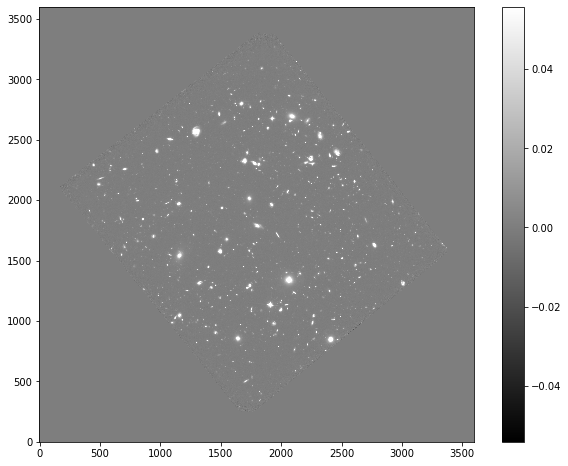

In [3]:
# read image into standard 2-d numpy array
# NOTE: for astropy, the file needs to first be read into Header Data Unit List (or HDUL) format
# then from there the data values are saved separately
# hdul = fits.open("data/image.fits")
hdul = fits.open("data/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
hdul.info()

data = hdul[0].data

data = data.byteswap(inplace=True).newbyteorder()

# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

### Background subtraction
Most optical/IR data must be background subtracted before sources can be detected. In SEP, background estimation and source detection are two separate steps.

In [4]:
# measure a spatially varying background on the image
bkg = sep.Background(data)

There are various options for controlling the box size used in estimating the background. It is also possible to mask pixels. For example:

In [5]:
bkg = sep.Background(data, mask=None, bw=64, bh=64, fw=3, fh=3)

See the reference section for descriptions of these parameters.

This returns an Background object that holds information on the spatially varying background and spatially varying background noise level. We can now do various things with this Background object:

In [6]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [7]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

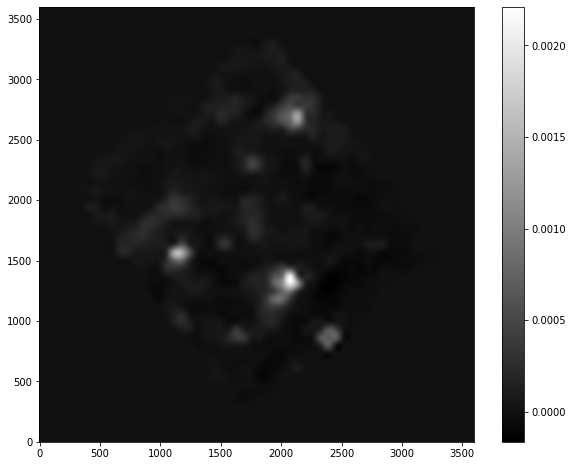

In [8]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [9]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

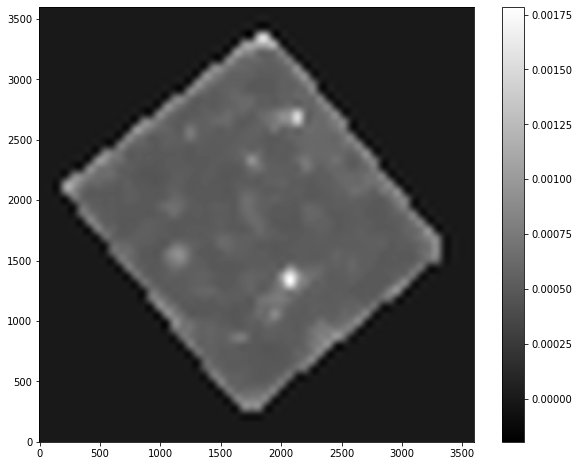

In [10]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [11]:
# subtract the background
data_sub = data - bkg

One can also subtract the background from the data array in-place by doing bkg.subfrom(data).

### Object detection
Now that we’ve subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we’re setting the detection threshold to be a constant value of 1.5σ where σ is the global background RMS.

In [12]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

sep.extract has many options for controlling detection threshold, pixel masking, filtering, and object deblending. See the reference documentation for details.

objects is a NumPy structured array with many fields.

In [13]:
# how many objects were detected
len(objects)

8643

objects['x'] and objects['y'] will give the centroid coordinates of the objects. Just to check where the detected objects are, we’ll over-plot the object coordinates with some basic shape parameters on the image:

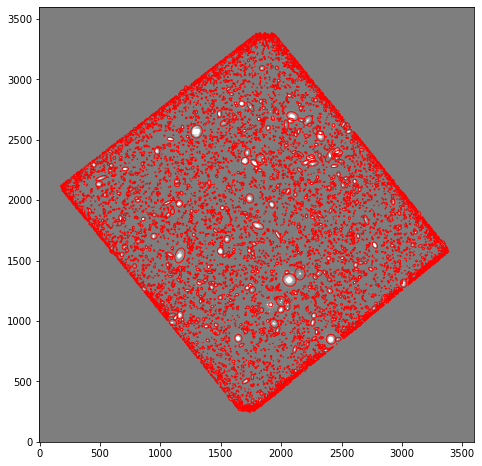

In [14]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

objects has many other fields, giving information such as second moments, and peak pixel positions and values. See the reference documentation for sep.extract for descriptions of these fields. You can see the available fields:

In [15]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

### Aperture photometry
Finally, we’ll perform simple circular aperture photometry with a 3 pixel radius at the locations of the objects:

In [16]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

flux, fluxerr and flag are all 1-d arrays with one entry per object.

In [17]:
# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


### Finally a brief word on byte order
If you are using SEP to analyze data read from FITS files with astropy.io.fits you may see an error message such as:

ValueError: Input array with dtype '>f4' has non-native byte order.
Only native byte order arrays are supported. To change the byte
order of the array 'data', do 'data = data.byteswap().newbyteorder()'

It is usually easiest to do this byte-swap operation directly after reading the array from the FITS file. You can even perform the byte swap in-place by doing

In [36]:
# data = data.byteswap(inplace=True).newbyteorder()

If you do this in-place operation, ensure that there are no other references to data, as they will be rendered nonsensical.

For the interested reader, this byteswap operation is necessary because astropy.io.fits always returns big-endian byte order arrays, even on little-endian machines.

***
## Flux Histogram

(array([8.64e+03, 1.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([ -1.06136543,  79.77449947, 160.61036437, 241.44622927,
        322.28209417, 403.11795907, 483.95382397, 564.78968887,
        645.62555377, 726.46141867, 807.29728357]),
 <BarContainer object of 10 artists>)

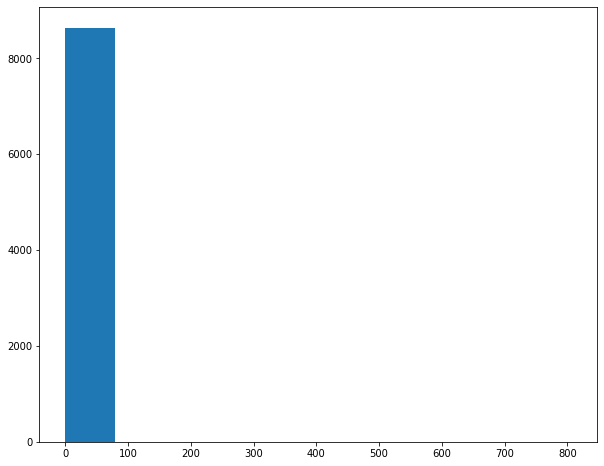

In [37]:
plt.hist(flux, bins=10)